# Global Terrorist Attacks
Global Terrorism Database (GTD) is an open-source database including information on terrorist events around the world from 1970 through 2014. Some portion of the attacks have not been attributed to a particular terrorist group.

In this project we develop a machine learning model that uses features such as attack type, weapons used, description of the attack, etc.to predict what group may have been responsible for a terrorist incident.


In [2]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None) 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 22
import seaborn as sns

# featuretools for automated feature engineering
import featuretools as ft

# Models 
import lightgbm as lgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

#Evaluation metrics and tools needed
from sklearn.model_selection import cross_val_score, GridSearchCV, ShuffleSplit
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score, precision_recall_fscore_support

# sklearn preprocessing for dealing with categorical variables
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder

# Loading the Global terrorism data and getting it ready for our analysis 

In [3]:
#loading GTD from 1970 to 2016 (note that we are interested in data from 1970 to 2014)
df=pd.read_excel('globalterrorismdb_0718dist.xlsx')
df.head()

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,197000000001,1970,7,2,NaN,0,NaT,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,197000000002,1970,0,0,NaN,0,NaT,130,Mexico,1,North America,Federal,Mexico city,19.371887,-99.086624,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,197001000001,1970,1,0,NaN,0,NaT,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,197001000002,1970,1,0,NaN,0,NaT,78,Greece,8,Western Europe,Attica,Athens,37.997490,23.762728,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN

We are interested in data from 1970 to 2014 so we select them

In [4]:
# Selecting data of years needed for our analysis 
df=df[df['iyear']<2015]
# displayed the last 10 rows to verify our selected data
df.tail(10)

,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
142231,201412310098,2014,12,31,NaN,0,NaT,603,United Kingdom,8,Western Europe,Northern Ireland,Magherafelt,54.755402,-6.606029,1.0,0,NaN,12/31/2014: Assailants threw two petrol bombs ...,1,1,1,0.0,NaN,NaN,0.0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,14,Private Citizens & Property,76.0,House/Apartment/Residence,Not Applicable,House of Civilian: Roberta Wilson,233.0,Northern Ireland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,Incendiary,19.0,Molotov Cocktail/Petrol Bomb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A petrol bomb was used in the attack.,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,Minor (likely < $1 million),-99.0,A window and door of a house were damaged in t...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Investigation after petrol bomb attack in Co ...","""Elderly woman survives petrol bomb attack,"" N...",NaN,START Primary Collection,-9,-9,1,1,NaN
142232,201412310099,2014,12,31,NaN,0,NaT,96,Ireland,8,Western Europe,Waterford,Waterford,52.255039,-7.123080,1.0,0,NaN,12/31/2014: Assailants threw a petrol bomb at ...,1,1,1,0.0,NaN,NaN,0.0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,14,Private Citizens & Property,76.0,House/Apartment/Residence,Not Applicable,House,96.0,Ireland,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,-99.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,Incendiary,19.0,Molotov Cocktail/Petrol Bomb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A petrol bomb was used in the attack.,0.0,0.0,0.0,0.0,0.0,0.0,1,3.0,Minor (likely < $1 million),-99.0,A home was damaged in this attack.,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"""Family escape injury in petrol bomb attack,"" ...","""Waterford gardaí 'don't have the resources' n...",NaN,START Primary Collection,-9,-9,0,-9,NaN
142233,201412310101,2014,12,31,NaN,0,NaT,155,West Bank and Gaza Strip,10,Middle East & North Africa,West Bank,Yatta,31.444601,35.091068,1.0,0,NaN,12/31/2014: Assailants threw incendiary device...,1,1,1,0.0,NaN,NaN,0.0,1,0,7,Facility/Infrastructure Attack,NaN,NaN,NaN,NaN,14,Private Citizens & Property,76.0,House/Apartment/Residence,Not Applicable,House,155.0,West Bank and Gaza Strip,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Israeli settlers,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,2.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8,Incendiary,19.0,Molotov Cocktail/Petrol Bomb,NaN,NaN,NaN,NaN,NaN,N

removed any duplicates

In [5]:
df=df.drop_duplicates()
df.shape

(142239, 135)

# Explodatory data analysis
Here, statistics of the terrorist dataframe (df) are calculated and figures plotted to outlined trends, anomalies, patterns or othere relationships within the data. We start by providing a general overview of the data and narrow in on aspects that will be of interest and informs our feature selection and engineering as well as our model selction.
#### Preliminary analysis to provide some insight of the dataframe 

In [6]:
# size of data
print('Dataframe has %d rows and %d columns'%(df.shape[0], df.shape[1]))

Dataframe has 142239 rows and 135 columns


In [7]:
# a glimpse at the target column (gname: the group name column)
df['gname'].value_counts()


Unknown                                                        66067
Shining Path (SL)                                               4543
Taliban                                                         4270
Farabundo Marti National Liberation Front (FMLN)                3351
Irish Republican Army (IRA)                                     2671
Revolutionary Armed Forces of Colombia (FARC)                   2398
Basque Fatherland and Freedom (ETA)                             2024
New People's Army (NPA)                                         1920
Al-Shabaab                                                      1757
Islamic State of Iraq and the Levant (ISIL)                     1623
Liberation Tigers of Tamil Eelam (LTTE)                         1606
Communist Party of India - Maoist (CPI-Maoist)                  1588
Kurdistan Workers' Party (PKK)                                  1455
National Liberation Army of Colombia (ELN)                      1375
Boko Haram                        

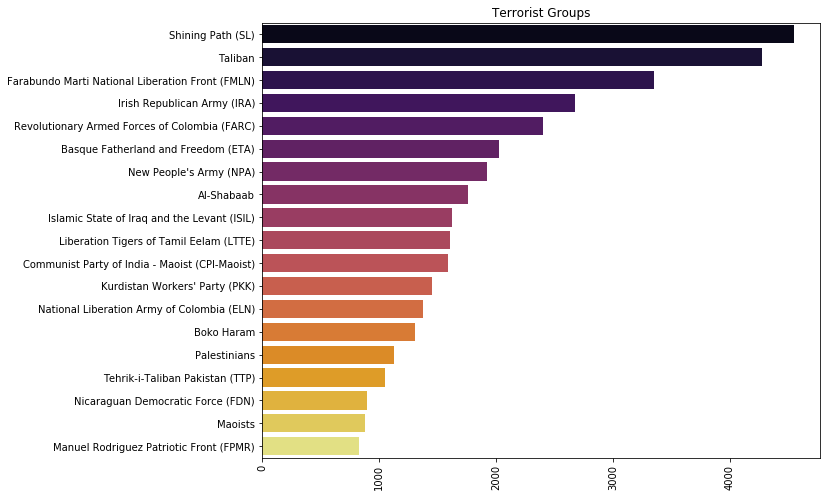

In [8]:
#Ploted top 20 groups for a better visualization
sns.barplot(df['gname'].value_counts()[1:20].values,df['gname'].value_counts()[1:20].index,palette=('inferno'))
plt.xticks(rotation=90)
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.title('Terrorist Groups')
plt.show()

It can be observed from the above  value count and plot that there are groups with far more terrorist attacks than others that results to an imbalance. Weights can be added to classes by their representation in the data during our machine learning model selection and hyper parameter setting to reflect this imbalance. We will revisit this in later sections of our analysis.

## Analysing missing values

A function to determine missing values is created for use on other dataset when the need arises

In [9]:
# Function to calculate missing values by column 
def missing_data(df):
    # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    percent = (100*df.isnull().sum()/df.isnull().count())

     # Creating a table with the results
    mis_val_table = pd.concat([mis_val, percent], axis=1, keys=['Missing Values', '% of Total Values']).sort_values('% of Total Values', ascending = False)  
    mis_val_table = mis_val_table[ mis_val_table.iloc[:,1] != 0]   

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table.shape[0]) +
              " columns that have missing values.")
    return mis_val_table

In [10]:
missing_data(df).head(20)

Your selected dataframe has 135 columns.
There are 106 columns that have missing values.


,Missing Values,% of Total Values
gsubname3,142235,99.997188
claimmode3,142178,99.957114
claimmode3_txt,142178,99.957114
weapsubtype4_txt,142169,99.950787
weapsubtype4,142169,99.950787
weaptype4,142166,99.948678
weaptype4_txt,142166,99.948678
gsubname2,142135,99.926884
claim3,142127,99.921259
guncertain3,142125,99.919853


Quiet a number of columns have high percentage of missing data. Columns with significant missing data will be dropped while those with less missing values will be filled with their mean or median(imputation). Some learning models such as XGBoost can handle missing values with no need for imputation. However, considering the number of columns with high percentage of missing values in our case, we will proceed to handle the missing values manually.

Columns with missing values greater than 5% or approximately 5000 will be removed.

In [11]:
# removing columns with data greater than 5000
for i in df.columns:
    if df[i].isnull().sum()>5000:
        df.drop(columns=i, inplace=True)
df.shape

(142239, 41)

In [12]:
#Further reading of the documentation on the dataset informs the droping of the following columns

df.drop(columns=['eventid', 'extended', 'country_txt', 'region_txt', 'specificity', 'vicinity',
                 'crit1', 'crit2', 'crit3', 'attacktype1_txt', 'targtype1_txt', 'natlty1_txt',
                 'guncertain1', 'individual', 'weaptype1_txt', 'dbsource', 'INT_MISC'], inplace=True)
df.shape

(142239, 24)

In [13]:
missing_data(df).head(20)

Your selected dataframe has 24 columns.
There are 9 columns that have missing values.


,Missing Values,% of Total Values
longitude,4349,3.057530
latitude,4348,3.056827
natlty1,1014,0.712885
target1,636,0.447135
city,434,0.305120
provstate,419,0.294575
ishostkid,178,0.125141
doubtterr,1,0.000703
multiple,1,0.000703


In [14]:
# we drop single rows in  doub

In [15]:
#making copy of my data
df_copy=df
#Droping the rows with 1 missing data
df_copy = df_copy[df_copy['doubtterr'].notnull()]
#Droping the rows with 1 missing data
df_copy = df_copy[df_copy['multiple'].notnull()]


df_copy.shape


(142237, 24)

In [16]:
missing_data(df_copy).head(20)

Your selected dataframe has 24 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
longitude,4349,3.057573
latitude,4348,3.056870
natlty1,1014,0.712895
target1,636,0.447141
city,434,0.305125
provstate,419,0.294579
ishostkid,178,0.125143


## Filling remaining missing data

As explained earlier, some models could handle missing data without the need for imputation. We would work with the copy of the data so that the original data can be preserved and used with other models.

In [17]:
# Missing natlty1 data values will be replace with the mode
df_copy['natlty1'] = df_copy['natlty1'].fillna(df_copy['natlty1'].mode()[0])

# Other missing values of Numerical columns are replaced with 0
for num in ("longitude",'latitude','ishostkid'):
    df_copy[num] = df_copy[num].fillna(0)

#Then missing values of categorical columns are replaced with none
for col in ("target1", "provstate", "city"):
    df_copy[col] = df_copy[col].fillna("None")
    
    
# checked if there still missing data
missing_data(df_copy).head(20)

Your selected dataframe has 24 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


## Anomalies
Here, we explore columns of interest to see if there are any outliers or mistyped information. These may result in anaomalies which may affect our data.

We will start by plotting a frequency distribution of all the numerical columns. Then the statiscal info of those with suspicious anomalies will be explored further using "pd.describe()" 

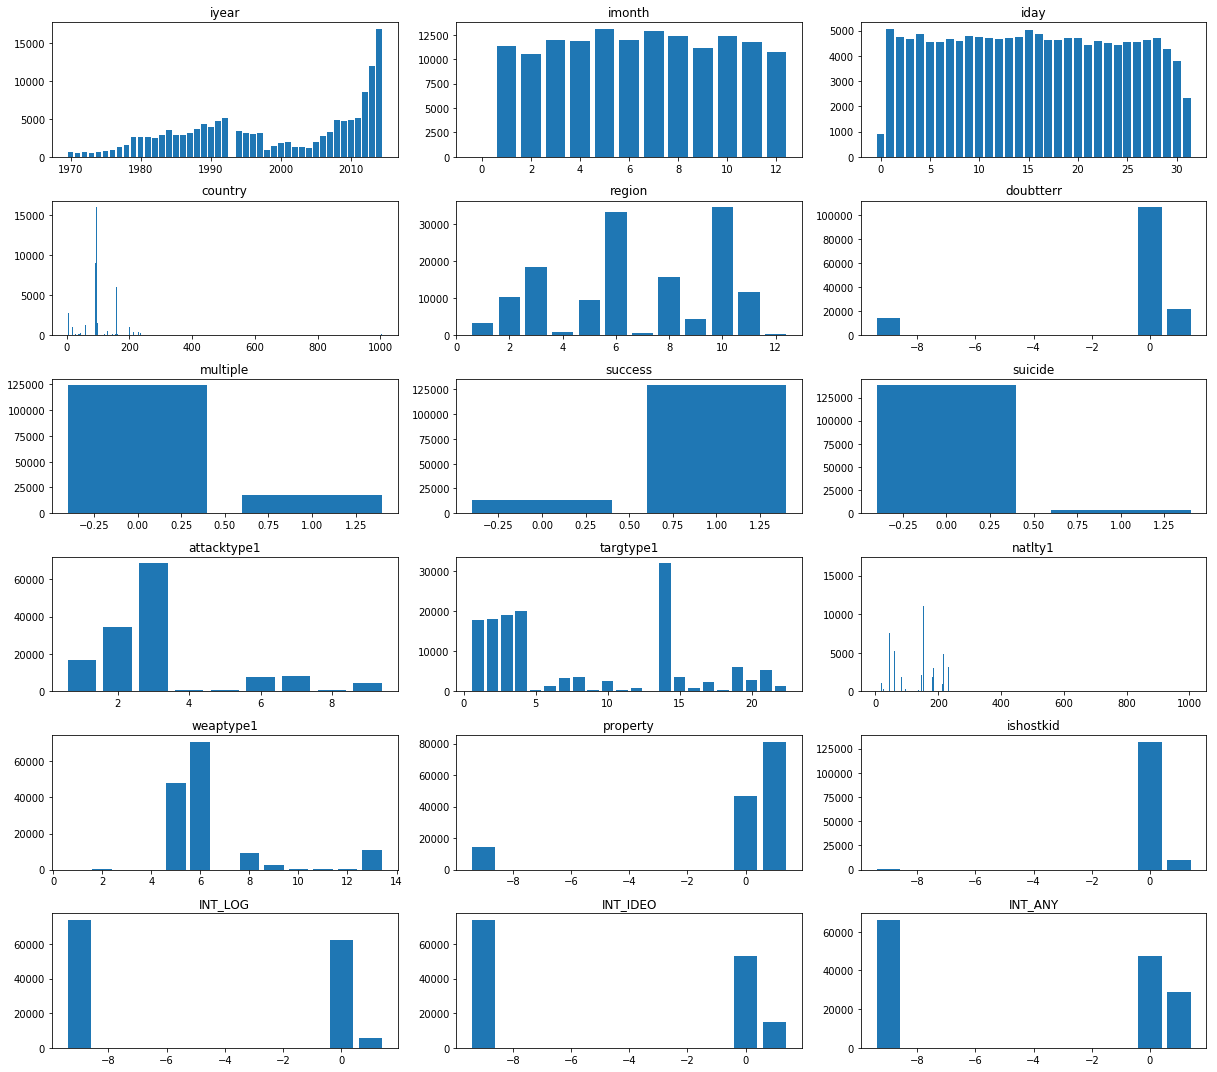

In [18]:
# checking frequency of column values
plt.figure(figsize=(17,15))
i = 0
for col in df_copy.columns:
    if col=='latitude' or col=='longitude' or col=='city' or col=='provstate' or col=='target1' or col=='gname':
        continue
    i += 1
    plt.subplot(6, 3, i)
    num_list = df_copy[col].value_counts()
    plt.bar(num_list.index, num_list.values)
    plt.title(col)
plt.tight_layout()   
plt.show()

 All the column frequency plots appear reasonable except for those classes with smaller sampling. This results in the skewedness of our plots. Hence, we will drop classes with less than 500 samples.

In [19]:
# dropping classes with less than 500 samples
num = df_copy['gname'].value_counts()
res = num.where(num>500).dropna()
res.index

Index(['Unknown', 'Shining Path (SL)', 'Taliban',
       'Farabundo Marti National Liberation Front (FMLN)',
       'Irish Republican Army (IRA)',
       'Revolutionary Armed Forces of Colombia (FARC)',
       'Basque Fatherland and Freedom (ETA)', 'New People's Army (NPA)',
       'Al-Shabaab', 'Islamic State of Iraq and the Levant (ISIL)',
       'Liberation Tigers of Tamil Eelam (LTTE)',
       'Communist Party of India - Maoist (CPI-Maoist)',
       'Kurdistan Workers' Party (PKK)',
       'National Liberation Army of Colombia (ELN)', 'Boko Haram',
       'Palestinians', 'Tehrik-i-Taliban Pakistan (TTP)',
       'Nicaraguan Democratic Force (FDN)', 'Maoists',
       'Manuel Rodriguez Patriotic Front (FPMR)',
       'Al-Qaida in the Arabian Peninsula (AQAP)', 'Sikh Extremists',
       'Corsican National Liberation Front (FLNC)', 'Al-Qaida in Iraq',
       'African National Congress (South Africa)',
       'Tupac Amaru Revolutionary Movement (MRTA)',
       'M-19 (Movement of April 1

In [63]:
df_copy1=df_copy[df_copy['gname'].isin(res.index)]
df_copy1.head()

,iyear,imonth,iday,country,region,provstate,city,latitude,longitude,doubtterr,multiple,success,suicide,attacktype1,targtype1,target1,natlty1,gname,weaptype1,property,ishostkid,INT_LOG,INT_IDEO,INT_ANY
2,1970,1,0,160,5,Tarlac,Unknown,15.478598,120.599741,0.0,0.0,1,0,1,10,Employee,217.0,Unknown,13,0,0.0,-9,-9,1
3,1970,1,0,78,8,Attica,Athens,37.997490,23.762728,0.0,0.0,1,0,3,7,U.S. Embassy,217.0,Unknown,6,1,0.0,-9,-9,1
4,1970,1,0,101,4,Fukouka,Fukouka,33.580412,130.396361,-9.0,0.0,1,0,7,7,U.S. Consulate,217.0,Unknown,8,1,0.0,-9,-9,1
7,1970,1,2,217,1,California,Oakland,37.791927,-122.225906,1.0,0.0,1,0,3,21,Edes Substation,217.0,Unknown,6,1,0.0,-9,-9,-9
12,1970,1,8,98,8,Lazio,Rome,41.890961,12.490069,-9.0,0.0,1,0,4,6,Flight 802 Boeing 707,217.0,Unknown,5,0,0.0,-9,-9,1


In [21]:
df_copy1.shape

(107208, 24)

## Column Type
Here, we will take a look at the number of columns for each data type


In [22]:
# Number of each type of column
df_copy1.dtypes.value_counts()

int64      14
float64     6
object      4
dtype: int64

In [23]:
#examine number of unique entries in each of the object (categorical) columns
df_copy1.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

provstate     2283
city         21046
target1      56058
gname           27
dtype: int64

Categorical features have to be transformed to numerical columns since most machine learning models can't work with categorical features except a few like LightGBM. Since uniques values for these categorical columns are really large, cureful analysis is required to choose suitable encoding strategy. Prior to encoding the categorised columns, let's separate the test data(features related to the unknown group), training data and the target label.

In [24]:
#Getting test data
df_test=df_copy1[df['gname']== "Unknown"]
print(df_test.shape)
df_test.head()

(66066, 24)


,iyear,imonth,iday,country,region,provstate,city,latitude,longitude,doubtterr,multiple,success,suicide,attacktype1,targtype1,target1,natlty1,gname,weaptype1,property,ishostkid,INT_LOG,INT_IDEO,INT_ANY
2,1970,1,0,160,5,Tarlac,Unknown,15.478598,120.599741,0.0,0.0,1,0,1,10,Employee,217.0,Unknown,13,0,0.0,-9,-9,1
3,1970,1,0,78,8,Attica,Athens,37.997490,23.762728,0.0,0.0,1,0,3,7,U.S. Embassy,217.0,Unknown,6,1,0.0,-9,-9,1
4,1970,1,0,101,4,Fukouka,Fukouka,33.580412,130.396361,-9.0,0.0,1,0,7,7,U.S. Consulate,217.0,Unknown,8,1,0.0,-9,-9,1
7,1970,1,2,217,1,California,Oakland,37.791927,-122.225906,1.0,0.0,1,0,3,21,Edes Substation,217.0,Unknown,6,1,0.0,-9,-9,-9
12,1970,1,8,98,8,Lazio,Rome,41.890961,12.490069,-9.0,0.0,1,0,4,6,Flight 802 Boeing 707,217.0,Unknown,5,0,0.0,-9,-9,1


In [25]:
#droping the gname column with unknow which we have to predict
df_test= df_test.drop(["gname"], axis= 1)

#Created the training dataset out of df_copy(i.e the dataframe without the Unknown)
df_train=df_copy1[df['gname']!= "Unknown"]
print(df_train.shape)
df_train.head()
 

(41142, 24)


,iyear,imonth,iday,country,region,provstate,city,latitude,longitude,doubtterr,multiple,success,suicide,attacktype1,targtype1,target1,natlty1,gname,weaptype1,property,ishostkid,INT_LOG,INT_IDEO,INT_ANY
39,1970,1,31,160,5,Tarlac,Bamban,15.675051,120.331618,1.0,0.0,0,0,9,4,Seaman,217.0,New People's Army (NPA),13,0,0.0,0,1,1
169,1970,4,2,160,5,Pampanga,Mabalacat City,15.185916,120.541870,1.0,0.0,1,0,9,4,Airmen,217.0,New People's Army (NPA),13,0,0.0,0,1,1
226,1970,4,25,209,10,Istanbul,Istanbul,41.106178,28.689863,0.0,0.0,1,0,3,6,EL AL Office,97.0,Palestinians,6,1,0.0,1,0,1
253,1970,5,4,158,3,Asuncion,Asuncion,-25.282773,-57.635610,0.0,0.0,1,0,1,7,"Wife, 1st sec. Israli Emb + an employee (wounded)",97.0,Palestinians,5,0,0.0,1,0,1
364,1970,6,26,603,8,Northern Ireland,Londonderry,55.011562,-7.312045,0.0,0.0,0,0,2,17,"3 IRA members, 2 civilians",233.0,Irish Republican Army (IRA),8,1,0.0,0,0,1


In [26]:
#Need to separate the target column from the training dataframe
train_labels=df_train['gname']
#drop the label from the train and encode. the labe will be encoded separately with le enconding
df_train= df_train.drop(["gname"], axis= 1)
print(df_train.shape, df_test.shape)


(41142, 23) (66066, 23)


In [27]:
l_train=len(df_train)
# now we combine the  train and test data for the  encoding
combined_data= pd.concat((df_train, df_test)).reset_index(drop=True)

print("all_data shape: {}".format(combined_data.shape))
l_train

all_data shape: (107208, 23)


41142

# Feature engineering


### Encoding of categorical features(columns) in training data and test data

There are several ways to transfrom the categorical columns to numerical. These include label encoding, one hot encoding, feature husher, the bin scheme, e.t.c. One hot encoding could have been an obvious choice however, applying one hot encoding to the large class set (uniques values) in the categorical columns will result in a large feature set. Feature husher may mitigate the large feature set by allowing us to predetermine n-feature (where n will be the dimension of new features to be created). However, considering the class set, a suitable n feature will be the 1000's (relatively large). Choosing a smaller n may lead to feature clashing or poor representation of the classes. Moreso since some machine learning models could handle categorical we will resort to the simple Le encoding and later compare the performance of our developed models to models that work with categorical features.

In [28]:
# Label encoding encoding of the target label

# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in combined_data:
    if combined_data[col].dtype == 'object':
        # Train on the training data
        le.fit(combined_data[col])
        # Transform both training and testing data
        combined_data[col] = le.transform(combined_data[col])
        #df_test[col] = le.transform(df_test[col])
            
        # Keep track of how many columns were label encoded
        le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [29]:
#We separate them back into the train and test dataset
df_train=combined_data[:l_train]
df_train.tail()

,iyear,imonth,iday,country,region,provstate,city,latitude,longitude,doubtterr,multiple,success,suicide,attacktype1,targtype1,target1,natlty1,weaptype1,property,ishostkid,INT_LOG,INT_IDEO,INT_ANY
41137,2014,12,31,147,11,291,11787,11.175928,13.582191,0.0,0.0,1,0,6,14,29503,147.0,5,0,1.0,0,0,0
41138,2014,12,31,4,6,874,19719,36.896969,65.665857,0.0,0.0,1,0,1,14,19706,4.0,5,1,0.0,0,0,0
41139,2014,12,30,228,10,752,1233,14.762732,49.605728,0.0,1.0,1,0,2,3,32165,228.0,5,1,0.0,0,1,1
41140,2014,12,30,228,10,752,1233,14.762732,49.605728,0.0,1.0,1,0,2,3,32165,228.0,5,1,0.0,0,1,1
41141,2014,12,27,4,6,984,16292,33.566561,69.878354,0.0,0.0,1,0,3,14,13196,4.0,6,0,0.0,0,0,0


In [30]:
#the test data
df_test=combined_data[l_train :]
df_test.head()

,iyear,imonth,iday,country,region,provstate,city,latitude,longitude,doubtterr,multiple,success,suicide,attacktype1,targtype1,target1,natlty1,weaptype1,property,ishostkid,INT_LOG,INT_IDEO,INT_ANY
41142,1970,1,0,160,5,1993,19719,15.478598,120.599741,0.0,0.0,1,0,1,10,18040,217.0,13,0,0.0,-9,-9,1
41143,1970,1,0,78,8,152,1319,37.997490,23.762728,0.0,0.0,1,0,3,7,49053,217.0,6,1,0.0,-9,-9,1
41144,1970,1,0,101,4,664,6441,33.580412,130.396361,-9.0,0.0,1,0,7,7,49034,217.0,8,1,0.0,-9,-9,1
41145,1970,1,2,217,1,360,13896,37.791927,-122.225906,1.0,0.0,1,0,3,21,17319,217.0,6,1,0.0,-9,-9,-9
41146,1970,1,8,98,8,1096,16113,41.890961,12.490069,-9.0,0.0,1,0,4,6,19153,217.0,5,0,0.0,-9,-9,1


In [31]:
#label encoder tranformation of the target column
le.fit(train_labels)
train_labels=le.transform(train_labels)
train_labels

array([17, 17, 19, ...,  2,  2, 23], dtype=int64)

In [32]:
df_train['gname']=train_labels
df_train.head()

,iyear,imonth,iday,country,region,provstate,city,latitude,longitude,doubtterr,multiple,success,suicide,attacktype1,targtype1,target1,natlty1,weaptype1,property,ishostkid,INT_LOG,INT_IDEO,INT_ANY,gname
0,1970,1,31,160,5,1993,1862,15.675051,120.331618,1.0,0.0,0,0,9,4,39419,217.0,13,0,0.0,0,1,1,17
1,1970,4,2,160,5,1536,11476,15.185916,120.541870,1.0,0.0,1,0,9,4,6361,217.0,13,0,0.0,0,1,1,17
2,1970,4,25,209,10,853,8288,41.106178,28.689863,0.0,0.0,1,0,3,6,17241,97.0,6,1,0.0,1,0,1,19
3,1970,5,4,158,3,143,1284,-25.282773,-57.635610,0.0,0.0,1,0,1,7,51415,97.0,5,0,0.0,1,0,1,19
4,1970,6,26,603,8,1448,11269,55.011562,-7.312045,0.0,0.0,0,0,2,17,671,233.0,8,1,0.0,0,0,1,9


In [33]:
df_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

## Correlation
Correlation provides a better understanding of the relationship between features and the target variable. Here, we calculate the Pearson correlation coefficient between every variable and the target using the .corr dataframe method.

The correlation coefficient is not the greatest method to represent "relevance" of a feature, but it does give us an idea of possible relationships within the data. Some general interpretations of the absolute value of the correlation coefficent are:

.00-.19 “very weak”
.20-.39 “weak”
.40-.59 “moderate”
.60-.79 “strong”
.80-1.0 “very strong”

In [34]:
# Find correlations with the target and sort
correlations = df_train.corr()['gname'].sort_values()
correlations

region        -0.527359
country       -0.299894
natlty1       -0.251338
latitude      -0.166716
doubtterr     -0.135768
INT_ANY       -0.127511
INT_IDEO      -0.104903
multiple      -0.085910
longitude     -0.077130
INT_LOG       -0.035091
target1       -0.023991
iyear         -0.016860
imonth        -0.008815
attacktype1   -0.006850
targtype1     -0.001900
iday          -0.001800
weaptype1      0.000845
suicide        0.014911
success        0.021267
ishostkid      0.024164
city           0.032771
property       0.067193
provstate      0.085845
gname          1.000000
Name: gname, dtype: float64

from the correlation coefficients, it can be observed that "region" has the strongest correlation with the target group while "iday","weaptype1","attacktype","imonth" and targtype1 have very weak correlations. We could have mannualy dropped columns with very weak correlation coeeficient, however sklearn's feature importance will be used to confirm or  select the relevant featuress. Prior to doing that, let's explore the heatmap to understand relationship among features. 

## Correlation matrix or heatmap

The correlation matrix helps us understand the relation among features. When two features are strongly correlated, we need to drop one of them since they might both have the  same effect or impact on our prediction capability.

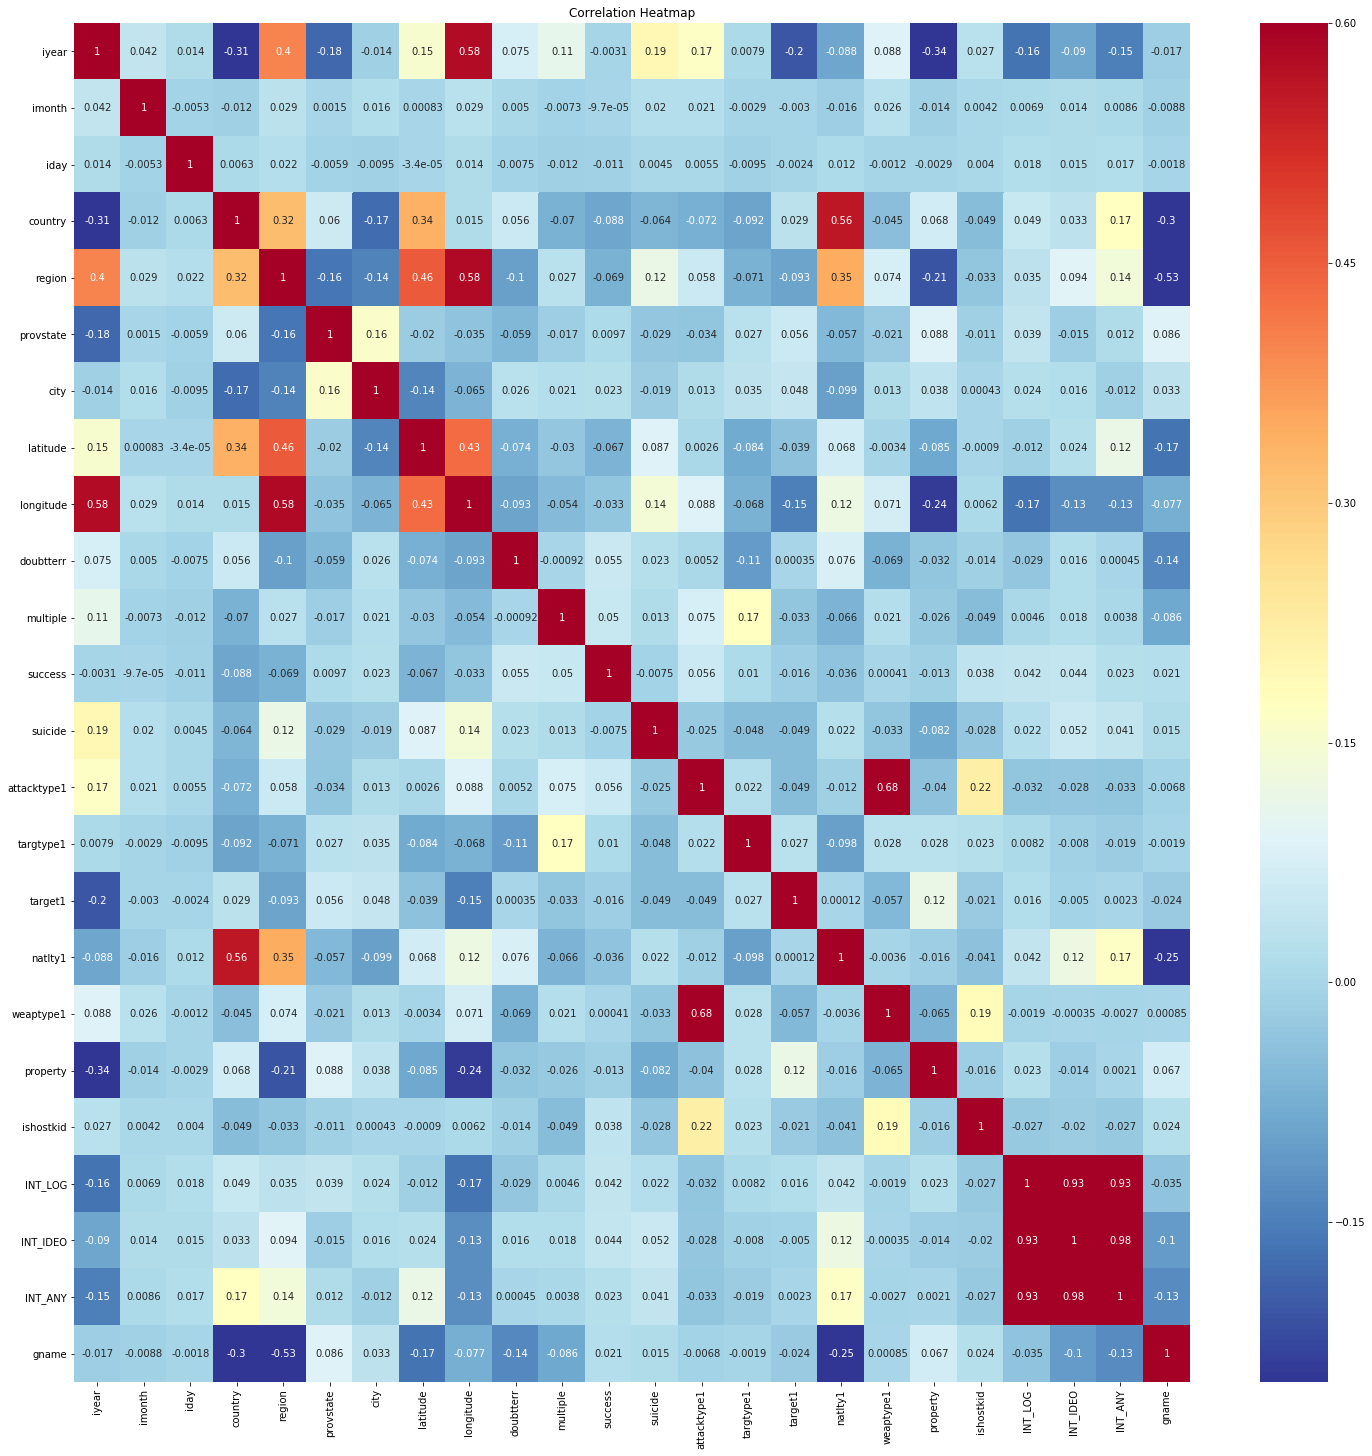

In [35]:
#building the correlation matrix
plt.figure(figsize = (25, 25))

# Heatmap of correlations
sns.heatmap(df_train.corr(), cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

Here it can be observed that the variable international ideology(INT_IDEO) and international miscellaneous (INT_ANY) are strongly correlated and probably provide information we can deduce from the other. Thus,INT_IDEO is dropped.

In [36]:
df_train= df_train.drop(["INT_IDEO"], axis= 1)
df_test= df_test.drop(["INT_IDEO"], axis= 1)
print(df_train.shape, df_test.shape)

(41142, 23) (66066, 22)


In [37]:
df_target=df_train['gname']
df_train= df_train.drop(["gname"], axis= 1)
df_train.shape

(41142, 22)

In [38]:
df_target.nunique()

26

## Feature Importance
A simple way to determine which variables are the most relevant is by using the feature importance functionality in XGBoost model library. It is also available in other models such as random forest and the like.

In [39]:
from xgboost import XGBClassifier
from xgboost import plot_importance
model = XGBClassifier( objective = 'multi:softmax', 
                                   class_weight = 'balanced', num_classes = 26)
model.fit(df_train, df_target,eval_metric = 'merror')

XGBClassifier(base_score=0.5, booster='gbtree', class_weight='balanced',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None, num_classes=26,
       objective='multi:softprob', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

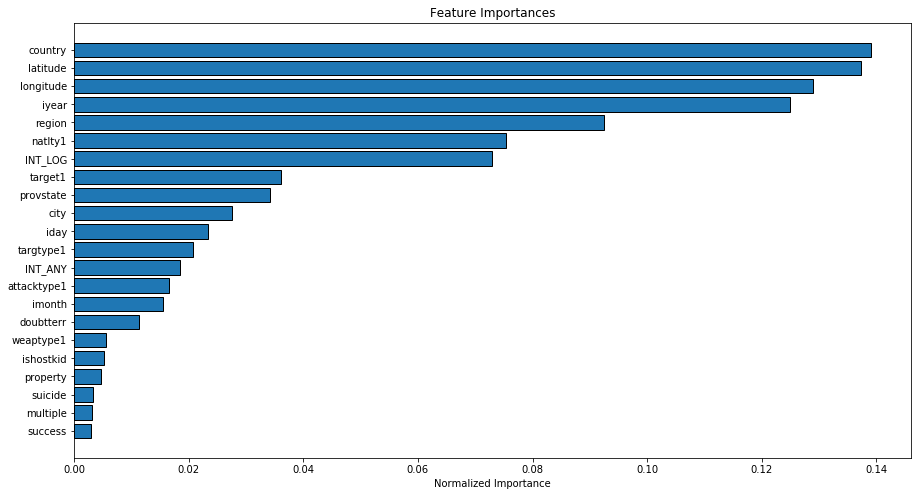

In [40]:
#function to plot feature taken for kaggle competition website
def plot_feature_importances(df):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    
    Args:
        df (dataframe): feature importances. Must have the features in a column
        called `features` and the importances in a column called `importance
        
    Returns:
        shows a plot of the 15 most importance features
        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
        
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (15, 8))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index))), 
            df['importance_normalized'], 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index))))
    ax.set_yticklabels(df['feature'])
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    return df
df1=pd.DataFrame({'feature': df_train.columns, 'importance': model.feature_importances_})
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(df1)

Incident (attack) locations (country, latitude and longitude) appear to be the most important features from the above plot. Also, it seems reasonable that the location of an attack may give the strongest indication of the group resposible for the attack. The plot re-emphasizes why the correlation coefficient may not be the greatest method to determine feature importance though it provides a general idea of feature relationships. Whiles the correlation coefficien suggest region as the strongest indicator of which group is resposible for an attack, the above plot suggest country as the strongest. However, the general idea behind both suggestions is location.

### Selecting important features: 
Given that, the plot outlines the important features, we will use feature selection library to select these important features. Prior to that we will store our train and test data for future use.

In [41]:
#copying traing and test data
df_train_1 = df_train.copy()
df_test_1= df_test.copy()

In [42]:
from sklearn.feature_selection import SelectFromModel

# We use the feature importances attribute to select the most important features
xgb_feat_imp = SelectFromModel(model, prefit = True)

# Reduce estimation, validation and test datasets
train = xgb_feat_imp.transform(df_train)
test = xgb_feat_imp.transform(df_test)


print("Results of 'feature_importances_':")
print('df_train: ', train.shape, '\ndf_test: ', test.shape)

Results of 'feature_importances_':
df_train:  (41142, 7) 
df_test:  (66066, 7)


Having selected the relevant features, we can split the data into training and validation data and have it ready for the machine learning models.


In [43]:
#spliting data into training and validation dataset
X_train, X_test, Y_train, Y_test = train_test_split(train, df_target, test_size=0.25, random_state=42, stratify=df_target)

# verify output
print('X_train: ', X_train.shape, '\nX_test: ', X_test.shape, '\nY_train: ', Y_train.shape, '\nY_test: ', Y_test.shape)

X_train:  (30856, 7) 
X_test:  (10286, 7) 
Y_train:  (30856,) 
Y_test:  (10286,)


# Model training

Here we will use our experience and knowledge in the field to short list some few models to train and compare performance. Since this is a classification problem, models for continuos variables or regressors are not considered. Ensembled models such randome forest regressors are aslo not considered b'cos we will be implementing ensemble in later part of our model training. Also, we attempted to select algorthims across the various subdivision of machine learning models:

K-Nearest Neighbors

Decision Tree

SVM

Naive Bayes

Neural Net



In [44]:
# setting algorithm parameters: mostly default
#al_names = ["K-Nearest Neighbors", "Decision Tree", "Linear SVM",  "Naive Bayes",  "Neural Net"]
al_names = ["K-Nearest Neighbors", "Decision Tree", "Naive Bayes",  "Neural Net"]

#models= [ KNeighborsClassifier(3), DecisionTreeClassifier(max_depth=5), SVC(kernel="linear", C=0.025), GaussianNB(), MLPClassifier(alpha=1)]

models= [ KNeighborsClassifier(3), DecisionTreeClassifier(class_weight='balanced'), GaussianNB(), MLPClassifier()]

In [45]:
# First I will use ShuffleSplit as a way of randomising the cross validation samples.
shuff = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

#create table to compare MLA metrics
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
prel_comparison = pd.DataFrame(columns = columns)

#index through models and save performance to table
row_index = 0
for alg in models:

    #set name and parameters
    model_name = alg.__class__.__name__
    prel_comparison.loc[row_index, 'Name'] = model_name
    prel_comparison.loc[row_index, 'Parameters'] = str(alg.get_params())
    
    alg.fit(X_train, Y_train)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    training_results = cross_val_score(alg, X_train, Y_train, cv = shuff, scoring = 'accuracy').mean()
    test_results = accuracy_score(Y_test, alg.predict(X_test)).mean()
    
    prel_comparison.loc[row_index, 'Train Accuracy Mean'] = (training_results)*100
    prel_comparison.loc[row_index, 'Test Accuracy'] = (test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 4
prel_comparison['Train Accuracy Mean'] = prel_comparison['Train Accuracy Mean'].apply(lambda x: round(x, decimals))

prel_comparison['Test Accuracy'] = prel_comparison['Test Accuracy'].apply(lambda x: round(x, decimals))
prel_comparison

1 KNeighborsClassifier trained...
2 DecisionTreeClassifier trained...
3 GaussianNB trained...
4 MLPClassifier trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",94.6150,94.8863
1,DecisionTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'gin...",93.7568,94.3418
2,GaussianNB,{'priors': None},90.9126,92.4849
3,MLPClassifier,"{'activation': 'relu', 'alpha': 0.0001, 'batch...",84.6642,82.8894


The above table outlines performance (scores) of individual models. Here it can be observed that KNeighborsClassifier and decision tree classifier performed relatively better than the others. Test accuracy here refers to validation test. Also note there are other deep learning models available in TensroFlow that may out perform the MLP from sklearn used here.

## Hyper parameters optimization or tuning

As earlier mentioned, we started with default parameters of the models so we could have a general overview of their performance. Now we will tune/ optimize hyper parameters of individual to see if it may yield better results. Note that, there are more powerful ways of autotuning these parameters. Here, we consider few parameter options and range due to memory limitation of the computer being used.



In [46]:
models= [ KNeighborsClassifier(), DecisionTreeClassifier(),GaussianNB(), MLPClassifier()]

KNN_param_grid = {'n_neighbors': [1,2,3]}
G_param_grid = {'priors': [None, None]}
DTC_param_grid = {'max_depth': range(45, 150, 2)}
MLP_param_grid = {'alpha': np.arange(0.001, 4, 0.1)}

params_grid = [KNN_param_grid, DTC_param_grid, G_param_grid,  MLP_param_grid]
#create table to compare MLA metrics
columns = ['Name', 'Parameters', 'Train Accuracy Mean', 'Test Accuracy']
optimized_model_comparison = pd.DataFrame(columns = columns)

row_index = 0
for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring= 'accuracy', n_jobs=-1)
    
    params_grid.pop(0)
    #set name and parameters
    model_name = alg.__class__.__name__
    optimized_model_comparison.loc[row_index, 'Name'] = model_name
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    optimized_model_comparison.loc[row_index, 'Parameters'] = str(gs_alg.best_params_)
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    
    optimized_training_results = gs_alg.best_score_
    optimized_test_results = accuracy_score(Y_test, gs_alg.predict(X_test)).mean()
    
    optimized_model_comparison.loc[row_index, 'Train Accuracy Mean'] = (optimized_training_results)*100
    optimized_model_comparison.loc[row_index, 'Test Accuracy'] = (optimized_test_results)*100
    
    row_index+=1
    print(row_index, alg.__class__.__name__, 'trained...')

decimals = 3
optimized_model_comparison['Train Accuracy Mean'] = optimized_model_comparison['Train Accuracy Mean'].apply(lambda x: round(x, decimals))
optimized_model_comparison['Test Accuracy'] = optimized_model_comparison['Test Accuracy'].apply(lambda x: round(x, decimals))
optimized_model_comparison

1 KNeighborsClassifier trained...
2 DecisionTreeClassifier trained...
3 GaussianNB trained...
4 MLPClassifier trained...


,Name,Parameters,Train Accuracy Mean,Test Accuracy
0,KNeighborsClassifier,{'n_neighbors': 3},94.615,94.886
1,DecisionTreeClassifier,{'max_depth': 111},95.367,95.654
2,GaussianNB,{'priors': None},90.913,92.485
3,MLPClassifier,{'alpha': 1.001},85.318,83.473


## Ensemble
From the above table , decision tree classifier continue to outperform the other models. Though we could easily select the best performing model and work with it, one can observe that individual models considered have varying degree of performance. We ensemble these models for better performance. In ensembling, it is believed thatputting together two more weak leaners can yield better performance.

### Stacking: 
First let's use our highly tuned models for stacking a trained and test dataset for the ensemble

In [47]:
#the stacking code are not original

models= [ KNeighborsClassifier(), DecisionTreeClassifier(),GaussianNB(), MLPClassifier()]

KNN_param_grid = {'n_neighbors': [1,2,3]}
G_param_grid = {'priors': [None, None]}
DTC_param_grid = {'max_depth': range(45, 150, 2)}
MLP_param_grid = {'alpha': np.arange(1, 4, 0.1)}

params_grid = [KNN_param_grid, DTC_param_grid, G_param_grid,  MLP_param_grid]

stacked_validation_train = pd.DataFrame()
stacked_test_train = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'accuracy', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(X_train, Y_train)
    gs_best = gs_alg.best_estimator_
    stacked_validation_train.insert(loc = row_index, column = al_names[0], value = gs_best.predict(X_test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking validation dataset...')
    
    stacked_test_train.insert(loc = row_index, column = al_names[0], value = gs_best.predict(test))
    print(row_index+1, alg.__class__.__name__, 'predictions added to stacking test dataset...')
    print("-"*50)
    al_names.pop(0)
    
    row_index+=1
    
print('Done')

1 KNeighborsClassifier predictions added to stacking validation dataset...
1 KNeighborsClassifier predictions added to stacking test dataset...
--------------------------------------------------
2 DecisionTreeClassifier predictions added to stacking validation dataset...
2 DecisionTreeClassifier predictions added to stacking test dataset...
--------------------------------------------------
3 GaussianNB predictions added to stacking validation dataset...
3 GaussianNB predictions added to stacking test dataset...
--------------------------------------------------
4 MLPClassifier predictions added to stacking validation dataset...
4 MLPClassifier predictions added to stacking test dataset...
--------------------------------------------------
Done


In [48]:
# Ensembling
al_names = ["K-Nearest Neighbors", "Decision Tree", "Naive Bayes",  "Neural Net"]
models= [ KNeighborsClassifier(), DecisionTreeClassifier(),GaussianNB(), MLPClassifier()]

KNN_param_grid = {'n_neighbors': [1,2,3]}
G_param_grid = {'priors': [None, None]}
DTC_param_grid = {'max_depth': range(45, 150, 2)}
MLP_param_grid = {'alpha': np.arange(1, 4, 0.1)}

params_grid = [KNN_param_grid, DTC_param_grid, G_param_grid,  MLP_param_grid]

final_predictions = pd.DataFrame()

row_index=0

for alg in models:
    
    gs_alg = GridSearchCV(alg, param_grid = params_grid[0], cv = shuff, scoring = 'accuracy', n_jobs=-1)
    params_grid.pop(0)
    
    gs_alg.fit(stacked_validation_train, Y_test)
    gs_best = gs_alg.best_estimator_
    final_predictions.insert(loc = row_index, column = al_names[0], value = gs_best.predict(stacked_test_train))
    
    print(row_index+1, alg.__class__.__name__, 'final results predicted added to table...')
    al_names.pop(0)
    
    row_index+=1

print("-"*50)
print("Done")
    
final_predictions.head()

1 KNeighborsClassifier final results predicted added to table...
2 DecisionTreeClassifier final results predicted added to table...
3 GaussianNB final results predicted added to table...
4 MLPClassifier final results predicted added to table...
--------------------------------------------------
Done


,K-Nearest Neighbors,Decision Tree,Naive Bayes,Neural Net
0,20,17,15,17
1,8,4,1,8
2,20,24,20,20
3,20,15,13,20
4,8,4,1,10


## Predicting groups with ensemble model

In [49]:
#Here we place more weight on decision tree since it performance was better.

ensemble =  final_predictions["K-Nearest Neighbors"]*(2.4/10)+ final_predictions["Decision Tree"]*(2.8/10)+ final_predictions["Naive Bayes"]*(2.4/10)+ final_predictions["Neural Net"]*(2.4/10)

#Predicting actual groups.

df_test["gname"]= np.round(ensemble.values)

df_test.head(5)

,iyear,imonth,iday,country,region,provstate,city,latitude,longitude,doubtterr,multiple,success,suicide,attacktype1,targtype1,target1,natlty1,weaptype1,property,ishostkid,INT_LOG,INT_ANY,gname
41142,1970,1,0,160,5,1993,19719,15.478598,120.599741,0.0,0.0,1,0,1,10,18040,217.0,13,0,0.0,-9,1,17.0
41143,1970,1,0,78,8,152,1319,37.997490,23.762728,0.0,0.0,1,0,3,7,49053,217.0,6,1,0.0,-9,1,5.0
41144,1970,1,0,101,4,664,6441,33.580412,130.396361,-9.0,0.0,1,0,7,7,49034,217.0,8,1,0.0,-9,1,21.0
41145,1970,1,2,217,1,360,13896,37.791927,-122.225906,1.0,0.0,1,0,3,21,17319,217.0,6,1,0.0,-9,-9,17.0
41146,1970,1,8,98,8,1096,16113,41.890961,12.490069,-9.0,0.0,1,0,4,6,19153,217.0,5,0,0.0,-9,1,6.0


In [50]:
df_origtest= df_test

In concluding, we transformed the numerical classes of the target (terrorist groups) into their original categorical classes so that, it will be easy to identify corresponding groups without necessary referring to their le numerical transformation or classes

In [51]:
#retriving original classes or groupings of terrorist groups
le_test_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_test_mapping


{'African National Congress (South Africa)': 0,
 'Al-Qaida in Iraq': 1,
 'Al-Qaida in the Arabian Peninsula (AQAP)': 2,
 'Al-Shabaab': 3,
 'Basque Fatherland and Freedom (ETA)': 4,
 'Boko Haram': 5,
 'Communist Party of India - Maoist (CPI-Maoist)': 6,
 'Corsican National Liberation Front (FLNC)': 7,
 'Farabundo Marti National Liberation Front (FMLN)': 8,
 'Irish Republican Army (IRA)': 9,
 'Islamic State of Iraq and the Levant (ISIL)': 10,
 "Kurdistan Workers' Party (PKK)": 11,
 'Liberation Tigers of Tamil Eelam (LTTE)': 12,
 'M-19 (Movement of April 19)': 13,
 'Manuel Rodriguez Patriotic Front (FPMR)': 14,
 'Maoists': 15,
 'National Liberation Army of Colombia (ELN)': 16,
 "New People's Army (NPA)": 17,
 'Nicaraguan Democratic Force (FDN)': 18,
 'Palestinians': 19,
 'Revolutionary Armed Forces of Colombia (FARC)': 20,
 'Shining Path (SL)': 21,
 'Sikh Extremists': 22,
 'Taliban': 23,
 'Tehrik-i-Taliban Pakistan (TTP)': 24,
 'Tupac Amaru Revolutionary Movement (MRTA)': 25}

In [56]:
#reverse elements of the dictionary so that the keys become values and the values become keys
le_test_mapping1={}
for keys, values in le_test_mapping.items():
    le_test_mapping1[value]=keys
    
le_test_mapping1


{0: 'African National Congress (South Africa)',
 1: 'Al-Qaida in Iraq',
 2: 'Al-Qaida in the Arabian Peninsula (AQAP)',
 3: 'Al-Shabaab',
 4: 'Basque Fatherland and Freedom (ETA)',
 5: 'Boko Haram',
 6: 'Communist Party of India - Maoist (CPI-Maoist)',
 7: 'Corsican National Liberation Front (FLNC)',
 8: 'Farabundo Marti National Liberation Front (FMLN)',
 9: 'Irish Republican Army (IRA)',
 10: 'Islamic State of Iraq and the Levant (ISIL)',
 11: "Kurdistan Workers' Party (PKK)",
 12: 'Liberation Tigers of Tamil Eelam (LTTE)',
 13: 'M-19 (Movement of April 19)',
 14: 'Manuel Rodriguez Patriotic Front (FPMR)',
 15: 'Maoists',
 16: 'National Liberation Army of Colombia (ELN)',
 17: "New People's Army (NPA)",
 18: 'Nicaraguan Democratic Force (FDN)',
 19: 'Palestinians',
 20: 'Revolutionary Armed Forces of Colombia (FARC)',
 21: 'Shining Path (SL)',
 22: 'Sikh Extremists',
 23: 'Taliban',
 24: 'Tehrik-i-Taliban Pakistan (TTP)',
 25: 'Tupac Amaru Revolutionary Movement (MRTA)'}

In [65]:
# replacing test target numerical classes with original groups
df_origtest2=df_origtest.replace({'gname':le_test_mapping1})
#dataframe with predicted target in or
df_origtest2.head(10)

,iyear,imonth,iday,country,region,provstate,city,latitude,longitude,doubtterr,multiple,success,suicide,attacktype1,targtype1,target1,natlty1,weaptype1,property,ishostkid,INT_LOG,INT_ANY,gname
41142,1970,1,0,160,5,1993,19719,15.478598,120.599741,0.0,0.0,1,0,1,10,18040,217.0,13,0,0.0,-9,1,New People's Army (NPA)
41143,1970,1,0,78,8,152,1319,37.997490,23.762728,0.0,0.0,1,0,3,7,49053,217.0,6,1,0.0,-9,1,Boko Haram
41144,1970,1,0,101,4,664,6441,33.580412,130.396361,-9.0,0.0,1,0,7,7,49034,217.0,8,1,0.0,-9,1,Shining Path (SL)
41145,1970,1,2,217,1,360,13896,37.791927,-122.225906,1.0,0.0,1,0,3,21,17319,217.0,6,1,0.0,-9,-9,New People's Army (NPA)
41146,1970,1,8,98,8,1096,16113,41.890961,12.490069,-9.0,0.0,1,0,4,6,19153,217.0,5,0,0.0,-9,1,Communist Party of India - Maoist (CPI-Maoist)
41147,1970,1,20,83,2,732,7208,14.622869,-90.529068,0.0,0.0,1,0,1,7,9835,216.0,13,0,0.0,-9,1,Irish Republican Army (IRA)
41148,1970,1,21,160,5,1261,15592,14.674280,121.057495,0.0,0.0,1,0,3,7,24672,217.0,6,1,0.0,-9,1,New People's Army (NPA)
41149,1970,1,28,499,9,259,2538,52.501530,13.401851,-9.0,0.0,1,0,7,3,37651,75.0,8,1,0.0,-9,1,New People's Army (NPA)
41150,1970,1,31,217,1,477,5148,39.758968,-104.876305,1.0,0.0,1,0,3,3,34211,217.0,6,1,0.0,-9,-9,Communist Party of India - Maoist (CPI-Maoist)
41151,1970,2,2,217,1,1392,13624,40.697132,-73.931351,0.0,0.0,0,0,7,1,28894,217.0,8,0,0.0,-9,-9,Irish Republican Army (IRA)
